In [3]:
print("Hell0")

Hell0


Number of No Smile Images: 1038
Number of Smile Images: 1168
Found 2206 images belonging to 2 classes.


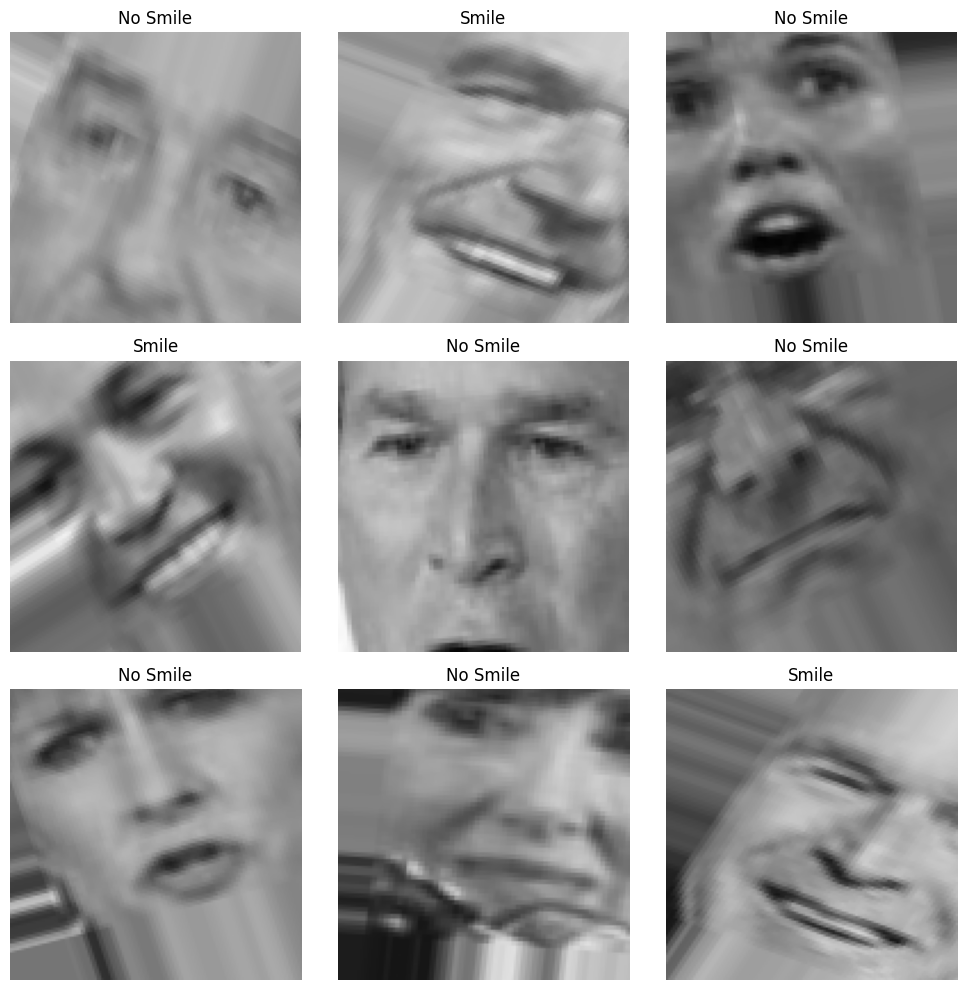

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the base directory for training data
base_dir = "/kaggle/input/face-smiles/Face_smile Classification"

# Define the specific directories for each class
negatives_dir = os.path.join(base_dir, "No_smile")
positives_dir = os.path.join(base_dir, "Smile")

# Count images in each folder
num_negatives = len(os.listdir(negatives_dir))
num_positives = len(os.listdir(positives_dir))

print(f"Number of No Smile Images: {num_negatives}")  # Expected: 1523
print(f"Number of Smile Images: {num_positives}")       # Expected: 11358

# Set parameters for image preprocessing and augmentation
img_width, img_height = 128, 128
batch_size = 32

# Create an ImageDataGenerator for augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=30,         # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally (20% of width)
    height_shift_range=0.2,    # Randomly shift images vertically (20% of height)
    shear_range=0.2,           # Shear transformation
    zoom_range=0.2,            # Zoom in/out on images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in newly created pixels after a rotation or shift
)

# Use flow_from_directory to load images from the base directory
# It expects that base_dir contains subdirectories for each class.
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # Use binary labels for "smile" vs "no smile"
)

# Optional: Display a few augmented images to verify preprocessing
# Get a single batch of images and labels from the generator
images, labels = next(train_generator)

# Plot the first 9 augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Smile" if labels[i] == 1 else "No Smile")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Define directories
# base_dir = "/kaggle/input/smile-classification/SmileClassification_Dataset/training"

# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Load pre-trained InceptionResNetV2 model + higher level layers
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:500]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Save the trained model
model.save("1smile_detection_model.h5")

Found 1766 images belonging to 2 classes.
Found 440 images belonging to 2 classes.
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 760ms/step - accuracy: 0.5276 - loss: 0.8537 - val_accuracy: 0.7114 - val_loss: 0.5737 - learning_rate: 1.0000e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - accuracy: 0.6748 - loss: 0.6359 - val_accuracy: 0.7091 - val_loss: 0.5578 - learning_rate: 1.0000e-04
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.6696 - loss: 0.6079 - val_accuracy: 0.7182 - val_loss: 0.5696 - learning_rate: 1.0000e-04
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy: 0.6698 - loss: 0.6036 - val_accuracy: 0.7409 - val_loss: 0.5221 - learning_rate: 1.0000e-04
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.7193 - loss: 0.5533 - val_accuracy: 0.7136 - val_loss: 0.5779 - learning_rate: 1.0000e-04
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy: 0.7131 - loss: 0.5785 - val_accuracy: 0.7545 - val_loss: 0.4937 - learning_rate: 1.0000e-04
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.72

In [7]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.7392 - loss: 0.5636
Validation Accuracy: 71.82%


In [10]:
final_val_accuracy = history.history['val_accuracy'][-1]
print("Final Validation Accuracy during training: {:.2f}%".format(final_val_accuracy * 100))

Final Validation Accuracy during training: 74.32%


##  Plot

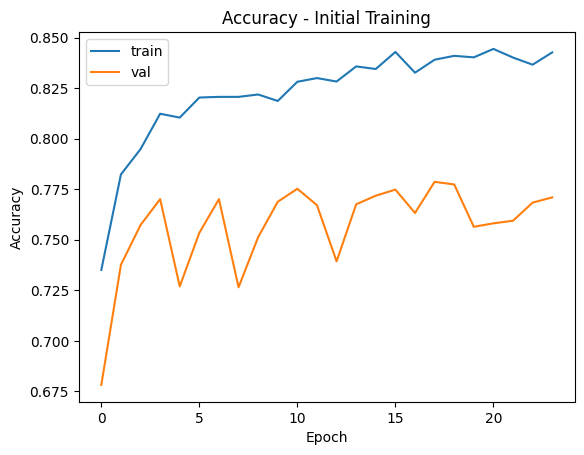

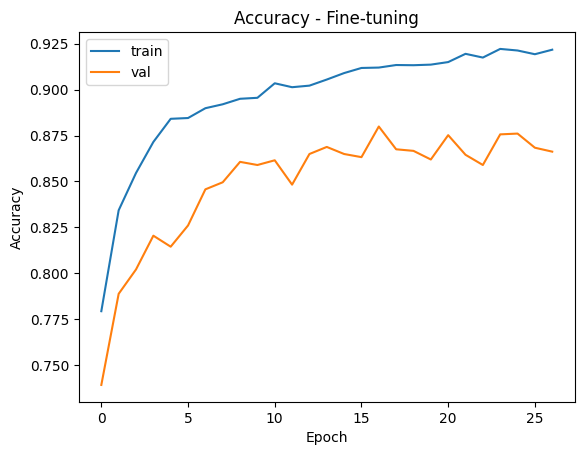

In [14]:
def plot_history(histories, titles):
    for history, title in zip(histories, titles):
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='val')
        plt.title(f'Accuracy - {title}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
plot_history([history, history_fine], ["Initial Training", "Fine-tuning"])

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# # Define base directory
# base_dir = "/kaggle/input/smile-classification/SmileClassification_Dataset/training"

# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Create generators
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Load pre-trained InceptionResNetV2 model (excluding top)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("best_smile_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Fine-tuning: Unfreeze some of the base layers
base_model.trainable = True
for layer in base_model.layers[:500]:
    layer.trainable = False  # Keep early layers frozen

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save final model
model.save("final_smile_detection_model.keras")

Found 9362 images belonging to 2 classes.
Found 2340 images belonging to 2 classes.
Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6901 - loss: 0.6065
Epoch 1: val_accuracy improved from -inf to 0.67821, saving model to best_smile_model.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 153s 436ms/step - accuracy: 0.6902 - loss: 0.6062 - val_accuracy: 0.6782 - val_loss: 0.6029 - learning_rate: 1.0000e-04
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7777 - loss: 0.4458
Epoch 2: val_accuracy improved from 0.67821 to 0.73761, saving model to best_smile_model.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 74s 250ms/step - accuracy: 0.7777 - loss: 0.4458 - val_accuracy: 0.7376 - val_loss: 0.5303 - learning_rate: 1.0000e-04
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7962 - loss: 0.4118
Epoch 3: val_accuracy improved from 0.73761 to 0.75726, saving model to best_smile_model.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 75s 251ms/step - accuracy: 0.7962 - loss: 0.

In [20]:
# Initial training
train_acc_init = history.history['accuracy'][-1]
val_acc_init   = history.history['val_accuracy'][-1]

# Fine‑tuning
train_acc_ft = history_fine.history['accuracy'][-1]
val_acc_ft   = history_fine.history['val_accuracy'][-1]

print(f"Initial training  accuracy: {train_acc_init*100:.2f}%")
print(f"Initial validation accuracy: {val_acc_init*100:.2f}%")
print(f"Fine‑tuning training  accuracy: {train_acc_ft*100:.2f}%")
print(f"Fine‑tuning validation accuracy: {val_acc_ft*100:.2f}%")

Initial training  accuracy: 84.27%
Initial validation accuracy: 77.09%
Fine‑tuning training  accuracy: 92.17%
Fine‑tuning validation accuracy: 86.62%


In [16]:
import matplotlib.pyplot as plt

# Combine history from the initial training and fine-tuning phases (if desired)
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(1, len(acc) + 1)

In [17]:
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

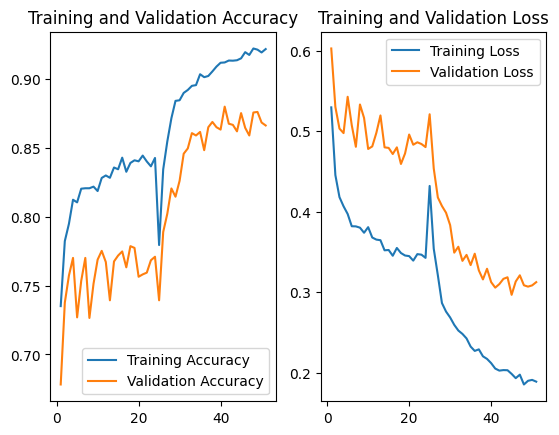

In [19]:
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Testing 

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Prediction: Smile


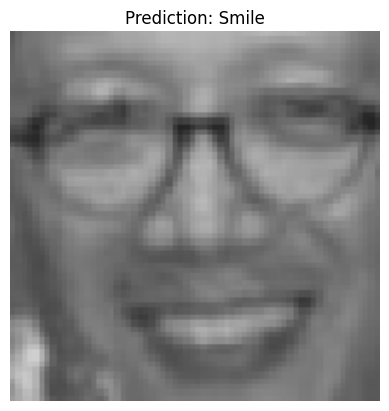

In [21]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("/kaggle/working/final_smile_detection_model.keras")

# Path to the image you want to predict
img_path = "/kaggle/input/face-smiles/Face_smile Classification/Smile/1009.jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch dimension
img_array /= 255.  # Rescale as during training

# Predict using the model
prediction = model.predict(img_array)

# Since this is a binary classification with sigmoid activation:
if prediction[0][0] > 0.5:
    print("Prediction: Smile")
else:
    print("Prediction: Not Smile")

# Optionally, display the image
plt.imshow(img)
plt.title("Prediction: Smile" if prediction[0][0] > 0.5 else "Prediction: Not Smile")
plt.axis('off')
plt.show()


In [22]:
from tensorflow.keras.models import load_model

# Load the best checkpoint
best_model = load_model("/kaggle/working/best_smile_model.keras")

# Evaluate
loss, acc = best_model.evaluate(validation_generator, verbose=0)
print(f"Best model validation accuracy: {acc*100:.2f}%")

Best model validation accuracy: 86.71%


In [27]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load your pre-trained model
model = load_model("/kaggle/working/final_smile_detection_model.keras")

# Initialize video capture with the default webcam (usually your laptop's built-in camera)
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Resize frame to the size expected by the model (150x150)
    resized_frame = cv2.resize(frame, (150, 150))
    
    # Preprocess the frame: convert to array, expand dims, and rescale pixel values
    img_array = img_to_array(resized_frame)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make a prediction with the model
    prediction = model.predict(img_array)
    label = "Smile" if prediction[0][0] > 0.5 else "Not Smile"

    # Display the label on the original frame
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2)

    # Show the live video feed with prediction
    cv2.imshow("Live Smile Detection", frame)

    # Break the loop when the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()